In [1]:
import os
import sys
import math
import timeit
import random
import json
import argparse
from argparse import Namespace

import numpy as np
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from datasets.LHSynthIterableDataset import LHSynthIterableDataset
from model.DepthGenLM import DepthGenLM

In [2]:
hparams = Namespace(**json.load(open(("/home/alex/dev/projects/3dhpe-udd/configs/resnet_base_pretrain.json"))))
model = DepthGenLM(hparams)
model.cuda()

DepthGenLM(
  (estimator): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [3]:
tsfms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(224, Image.NEAREST),
    torchvision.transforms.ToTensor()
])

scene_path = "/home/alex/dev/projects/libhand-public/nyu_synth/scene_spec.yml"
pose_config_path = "/home/alex/dev/projects/libhand-mesh-generator/configs/pose/train.json"
shape_config_path = "/home/alex/dev/projects/libhand-mesh-generator/configs/shape/train.json"

dataset = LHSynthIterableDataset(scene_path, pose_config_path, shape_config_path,
                                 tsfms, tsfms, 1024, True, 0.0)
dataset.setup(0)

<IPython.core.display.Javascript object>


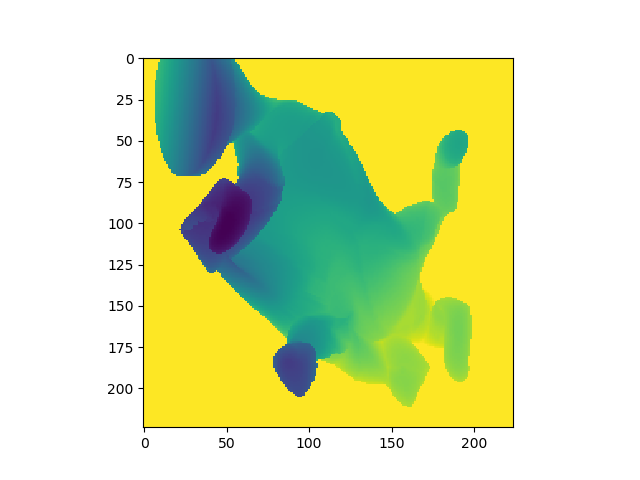

<IPython.core.display.Javascript object>


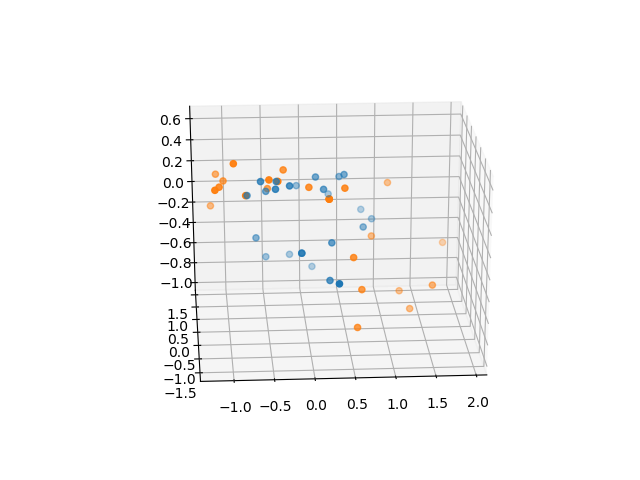

In [7]:
depth, kps = next(dataset)

preds = model(depth.unsqueeze(0).cuda())
img = preds[0]
coords = preds[1]

kps_vis = kps.cpu()
sample = depth.numpy()

segments = np.array([
    [2, 3],
    [3, 4],
    [4, 5],
    [7, 8],
    [8, 9],
    [9, 10],
    [12, 13],
    [13, 14],
    [14, 15],
    [17, 18],
    [18, 19],
    [19, 20],
    [22, 23],
    [23, 24],
    [24, 25]
])

%matplotlib notebook
img_fig = plt.figure()
img_ax = img_fig.add_subplot(111)
img_ax.imshow(img[0].detach().cpu())
# img_ax.imshow(sample[0])

kp_vis = kps.cpu()
coord_vis = coords[0].detach().cpu()

coord_fig = plt.figure()
coord_ax = coord_fig.add_subplot(111, projection='3d')
coord_ax.scatter(kp_vis[:, 0], kp_vis[:, 1], kp_vis[:, 2])
coord_ax.scatter(coord_vis[:, 0], coord_vis[:, 1], coord_vis[:, 2])